In [1]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import Image
# caffe_root = '/home/pil/DL/caffe_jh/'
# caffe_root = '/home/junho/caffe_jh/'
TensorFace_root = '/home/junho/TensorFace/'
DATA_PATH = '/home/pil/Dataset/face/'
DB_PATH = '/home/junho/jeewangue/DL/db/'

In [2]:
#TensorFlow!
import sys
import os
os.chdir(TensorFace_root)
import vggface
from pprint import pprint
import tensorflow as tf
import numpy as np

input_placeholder = tf.placeholder(tf.float32, shape=(1, 224, 224, 3))
network = vggface.VGGFace()
ses = tf.InteractiveSession()
network.load(ses,input_placeholder)
print "load complete"
# os.chdir(caffe_root)

load complete


In [13]:
# given im_path, extract descriptor
def face_discripor(im_path):
    # im_path='data/ak.png'
    net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(im_path))
    out = net.forward()
    v = net.blobs['fc7'].data[0].copy()
#     plt.plot(net.blobs['fc7'].data[0])
#     plt.figure()
#     im=Image.open(im_path)
#     plt.imshow(im)
#     print im.size
    return v
def face_discripor_tf(im_path):
    output = network.eval(feed_dict={input_placeholder:vggface.load_image(im_path)})[0]
    return output


import time
import datetime

# Batch computation of whole dataset. Return {'im_path':lst_im_path,'dscr': lst_discriptor}
def face_batch_discritor(lst_im_path, batch_size=128, disp_iter=1,fix_batch=False): 
#     batch_size = 128
    init_batch_size=batch_size # record b.c. last iter batch_size decreases.
    net.blobs['data'].reshape(batch_size,3,224,224)

    num_im = len(lst_im_path) # 50025
    if fix_batch:
        iteration=int(num_im/batch_size)
    else:
        iteration=int(num_im/batch_size)+1 # Including last batch.
    
    print "num of img:", num_im,"batch size: ",batch_size, ", batch comp total iter:",iteration,"disp by",disp_iter
    vectors_lst = []
    # Batch Computation
    t = time.time()
    t_prev_batch = t
    for batch_pass in range(0,iteration):#shoe_num/batch_size), 390
        if batch_pass == iteration-1: #Last batch. Possibly # of im < batch_size
            batch_size = num_im-batch_pass*batch_size# This is last_batch_size
            net.blobs['data'].reshape(batch_size,3,224,224)
            img_idx = range(batch_pass*batch_size, num_im) #im index    
        else:
            img_idx = range(batch_pass*batch_size,(batch_pass+1)*batch_size) #im index
        # Work fine with batch_pass=1:iteration-1
        for i in range(batch_size):
            im_path=lst_im_path[img_idx[i]]
#             print 'debugging', img_idx
            try:
                img=caffe.io.load_image(im_path)
            except Exception:
                p=im_path.split('/') # T.U.K. --> T.U.K
                p[-2]=p[-2][:-1]
                im_path='/'.join(p) 
                img=caffe.io.load_image(im_path)
            net.blobs['data'].data[i] = transformer.preprocess('data', img)
            
        # Now Forward Computation of the batch
#         print [(k, v.data.shape) for k, v in net.blobs.items()]
        out = net.forward()
        vectors =np.copy(net.blobs['fc7'].data[:batch_size])  
        vectors_lst.append(vectors)
        #visualize progress
        t_now = time.time()
        t_elapsed=t_now-t
        if batch_pass > iteration-5:
            disp_iter=1
        if batch_pass is iteration-1: #Last batch_size
            t=len(vectors_lst)
            msg='iter: '+ str(batch_pass+1)+' total # of img: '+str((t-1)*init_batch_size+batch_size)
            msg+=' elapsed '+time.strftime("%H:%M:%S", time.gmtime(t_elapsed)) +' sec'
            msg += '     %.2f' % (float(batch_pass+1)*100/iteration)+"%"
            print msg
        elif (batch_pass+1)%disp_iter==0: #Nomal batch size
            msg='iter: '+ str(batch_pass+1)+' total # of img: '+str(len(vectors_lst)*init_batch_size)
            msg+=' elapsed '+time.strftime("%H:%M:%S", time.gmtime(t_elapsed)) +' sec'
            msg += '     %.2f' % (float(batch_pass+1)*100/iteration)+"%"
            print msg
    lst_discriptor = np.concatenate(vectors_lst)
    print "number of img:", len(lst_discriptor)
    return {'im_path':lst_im_path,'dscr': lst_discriptor}

# Merge two db
def merge_db(db1, db2):
    return {'im_path':db1['im_path']+db2['im_path'],
            'dscr': np.concatenate([db1['dscr'],db2['dscr']])}

import pickle
def load_db(name):
    with open(os.path.join(DB_PATH, './face/'+name+'_list'), 'rb') as f:
        im_path = pickle.load(f)
    dscr = np.load(os.path.join(DB_PATH, './face/'+name+'_dscr.npy'))
    return {'im_path':im_path,
            'dscr': dscr}

def save_db(db,name):
    with open(os.path.join(DB_PATH, './face/'+name+'_list'), 'wb') as f:
        pickle.dump(db['im_path'], f)
    np.save(os.path.join(DB_PATH, './face/'+name+'_dscr.npy'), db['dscr'])
def cal_L2dist(vec1,vec2):
    diff= vec1-vec2
    return (np.sum(diff**2) / vec1.shape / 2.)[0]

# Retrieval closest 
def min_L2dist(vec,vectors,num_cand):
    L2dist=[]
    for i in range(len(vectors)):
        L2dist.append(cal_L2dist(vec,vectors[i]))
    temp = L2dist[:]
    # See distance
    #     plt.figure()
    #     plt.plot(temp)
    temp.sort()
    #     plt.figure()
    #     plt.plot(temp[:num_cand])
    closest=temp[:num_cand]
    #return [L2dist.index(i) for i in closest]   # Problem when duplicated element exist.
    def indices( mylist, value):
        return [i for i,x in enumerate(mylist) if x==value]
    def remove_duplicates(values):
        output = []
        seen = set()
        for value in values:
            # If value has not been encountered yet,
            # ... add it to both list and set.
            if value not in seen:
                output.append(value)
                seen.add(value)
        return output
    index_L2=[indices(L2dist,dist) for dist in remove_duplicates(closest)]
    return sum(index_L2, [])[:num_cand]

# _input can be int: index of db / str: 닮은꼴찾고싶은 사진. 
# k: 뽑고싶은 개수
# crop: 대조한 이미지의 cropped face를 보고 싶으면 True. defaut로 false
def visualize_top_k(_input, db, k=10,crop=False,platform='caffe'):
    lst_discriptor = db['dscr']
    lst_im_path = db['im_path']
    print len(lst_im_path)
    
    if type(_input) is int: #Find from db
        x=min_L2dist(lst_discriptor[_input],lst_discriptor,k)
    elif type(_input) is str: #Given image path
        try:
            if platform=='caffe':
                im_dscr = face_discripor(face_path+_input)
            elif platform=='tf':
                im_dscr = face_discripor_tf(face_path+_input)
        except Exception:
            print _input[-3:]
            if _input[-3:] == 'jpg':
                _input=_input[:-3]+'png'
            elif _input[-3:] == 'png':
                _input=_input[:-3]+'jpg'
            else:
                raise Exception('unacceptable file format. '+_input)
            if platform=='caffe':
                im_dscr = face_discripor(face_path+_input)
            elif platform=='tf':
                im_dscr = face_discripor_tf(face_path+_input)
        plt.figure()
        im=Image.open(face_path+'/'+_input)
        plt.imshow(im)
        x=min_L2dist(im_dscr,lst_discriptor,k)
    print 'x:', x
    close_faces = [lst_im_path[p] for p in x]
    print 'closest index:', x
    for i in range(len(close_faces)):
        plt.figure()
        if 'filtered' in close_faces[i].split('/'):
            im=Image.open(close_faces[i].replace('//filtered', '/animal')
                          .replace('png','jpg'))
        elif 'cropped' in close_faces[i].split('/'):
            im=Image.open(close_faces[i].replace('//cropped', '/animal')
                          .replace('png','jpg'))
            if crop:
                plt.subplot(121)
                plt.imshow(Image.open(close_faces[i]))
                plt.subplot(122)
            plt.imshow(im)
        else:
            im=Image.open('../../pil/caffe/'+close_faces[i]) #'../Dataset/face/h_jh.jpg
            plt.imshow(im)
        print close_faces[i]
print 'functions def done'

functions def done


In [14]:
import glob
# Make lists of im_path

# print face_path+os.listdir(face_path)

#HUMAN FACE
lst_f_im_path = glob.glob(DATA_PATH+'/h_*.png')+glob.glob(DATA_PATH+'/h_*.jpg')
lst_f_im_path= lst_f_im_path+['../lena.jpg','data/ak.png']

#ANIMAL FACE
# lst_im_path += glob.glob(face_path+'/filtered/*.png')
lst_a_im_path = glob.glob(DATA_PATH+'/cropped/*.jpg')
lst_a2_im_path = glob.glob(DATA_PATH+'animal_face/*/*.*')


lst_c_im_path = glob.glob(DATA_PATH+'img_align_celeba/*.jpg')

# compute 1by1. decaprecated. use face_batch_dicriptor.
# lst_v=[face_discripor(im_path) for im_path in lst_im_path]
print "done"

done


In [17]:
# db_animal = face_batch_discritor(lst_a_im_path, disp_iter=4)

# db_friends = face_batch_discritor(lst_f_im_path)
# db_animal = face_batch_discritor(lst_a_im_path)

# db_celeb = face_batch_discritor(lst_celeb_im_path,disp_iter=50)
# db_celeb = face_batch_discritor( lst_celeb_im_path[::],batch_size=128,disp_iter=1,fix_batch=True)



# save_db(db_animal,'animal')
# save_db(db_friends,'friends')

# db_animal2 = face_batch_discritor(lst_a2_im_path)
# save_db(db_animal2,'animal2')

db_animal=load_db('animal')
db_animal2=load_db('animal2')
db_friends=load_db('friends')
db_celeb=load_db('celebtest')

db_allanimal = merge_db(db_animal2,db_animal)
db_friendsceleb = merge_db(db_friends,db_celeb)

In [ ]:
# db_celebtest=load_db('db_celebtest')
# db_animal=load_db('animal')
# db_human=load_db('human')

In [ ]:
# 낙서장

lst = ['a','b','ac','bde','ase']
print [lst.pop(k) for k,v in enumerate(lst) if 'a' in v ]
# print len(lst_v)
# lst_h_discriptor.shape
# print db_animal

np.save('./jh_workspace/animal_dscr.npy', db_animal['dscr'])

4%3
print db_celeb['dscr'].shape, len(db_celeb['im_path'])
print len(set(lst_celeb_im_path[::1000]))
print  len(set(db_celeb['im_path']))
#

x = 'asdfawef.PNG'
x.lower()

In [6]:
!echo $CUDA_HOME

/usr/local/cuda-7.0-cudnnv2


In [6]:
face_path = '/home/pil/Dataset/face/'
output = network.eval(feed_dict={input_placeholder:vggface.load_image(face_path+'h_bk.png')})[0]
# result  = min_L2dist(output, vectors, 5)
# retriev = [im_path[i] for i in result]
# print retriev
output

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [7]:
visualize_top_k('h_hj2.png', db_friendsceleb,k=10,platform='caffe')

202648
png


NameError: global name 'transformer' is not defined

202648
png
x: [39, 42, 92075, 84949, 62813, 189375, 69012, 20805, 95578, 15405]
closest index: [39, 42, 92075, 84949, 62813, 189375, 69012, 20805, 95578, 15405]
../Dataset/face/h_jh.jpg
../Dataset/face/h_jh2.jpg
../Dataset/face/img_align_celeba/034577.jpg
../Dataset/face/img_align_celeba/147373.jpg
../Dataset/face/img_align_celeba/078174.jpg
../Dataset/face/img_align_celeba/064375.jpg
../Dataset/face/img_align_celeba/121931.jpg
../Dataset/face/img_align_celeba/103899.jpg
../Dataset/face/img_align_celeba/178628.jpg
../Dataset/face/img_align_celeba/160778.jpg


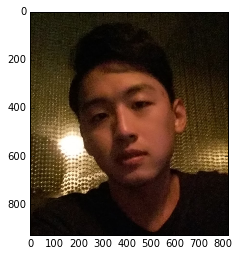

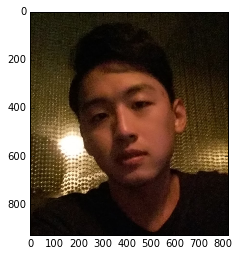

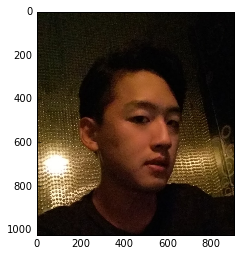

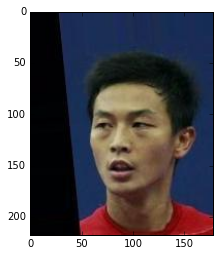

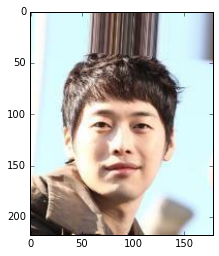

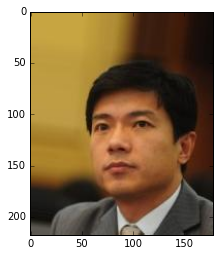

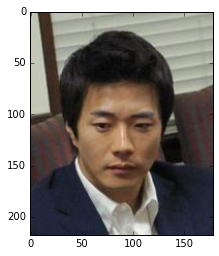

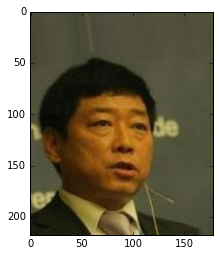

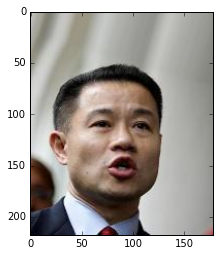

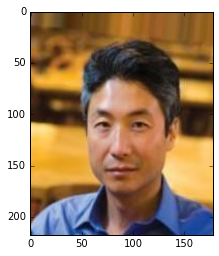

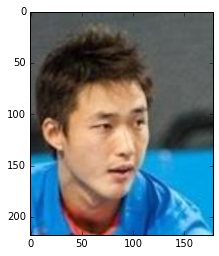

In [18]:
visualize_top_k('h_jh.png', db_friendsceleb,k=10,platform='tf')

In [ ]:
print [path.split('/')[-1] for path in lst_f_im_path],
# visualize_top_k('h_jhside.png', db_animal,k=15,crop=True)

# visualize_top_k('h_jyt.png', db_friendsceleb,k=10)
visualize_top_k('h_jh.png', db_friendsceleb,k=10)


# visualize_top_k(2147, db_allanimal,k=10)

# visualize_top_k('../'+lst_a2_im_path[2000], db_allanimal,k=15)


# visualize_top_k(90, db_celeb,k=15,crop=True)

In [ ]:

        
# visualize_top_k(21, lst_h_im_path, lst_h_discriptor)
# visualize_top_k(3220, lst_a_im_path, lst_a_discriptor,4)
# visualize_top_k('h_jh.jpg', lst_h_im_path, lst_h_discriptor,4)
#['h_jhside.png', 'h_kisum.png', 'h_girl2.png', 'h_girl.png', 'h_man.png', 'h_woman.png',
#'h_hj2.png', 'h_jyp.png', 'h_hj.png', 'h_hj3.png', 'h_dahui.png', 'h_man2.png', 'h_jinu.png',
#'h_jiwon.png', 'h_jh.jpg', 'h_jh_funny.jpg', 'h_obama.jpg', 'h_jh2.jpg', 'h_wg_noglasses.jpg',
#'h_sj.jpg', 'h_jh_glasses.jpg', 'h_wg.jpg', 'lena.jpg', 'ak.png']

print [path.split('/')[-1] for path in lst_h_im_path],

# visualize_top_k('h_jhside.png', db_animal,k=15,crop=True)
visualize_top_k('h_sj.png', db_celebtest,k=5)
# visualize_top_k(90, db_celeb,k=15,crop=True)
  


In [ ]:
# index.help()
x = [4,54,2,1,3,4,1,24,3,56,54,23,2]
print set(x)